# Analysis of  StarTracker - Serpent Walk

## Goal

Find hysteresis on the TMA point error. For this, the are two main exercices:
- Forward Az/El grid
- Backward Az/El grid

Both typical error on both paths should diverge if there is hysterisis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# function to read in the metadata that has been downloaded
import pandas as pd
def read_rubintv(fname):
    df = pd.read_json(fname).T
    df = df.dropna()
    times = df[['UTC','UTC wide']]
    
    df = df.drop(columns=['UTC','UTC wide'])
    df = df.astype(float)
    
    # set time vectors
    timenew = (today+'T'+ times['UTC'].to_numpy()).astype(np.datetime64)
    timenew2= (today+'T'+ times['UTC wide'].to_numpy()).astype(np.datetime64)
    
    df['UTC'] = pd.Series(timenew, index=df.index)
    df['UTC wide'] = pd.Series(timenew2, index=df.index)
    df['seq_num'] = df.index
    
    return df

In [3]:
def get_residual(df):    
    groups = df['groups'].to_numpy()
    keys = [np.where(groups==gi)[0] for gi in groups]
    ra = df['Calculated Ra wide'].to_numpy()
    dec = df['Calculated Dec wide'].to_numpy()

    base_ra = np.zeros_like(ra)
    base_dec = np.zeros_like(dec)
    for ix in keys:
        #base_ra[ix] = ra[ix][0]
        #base_dec[ix] = dec[ix][0]
        
        base_ra[ix] = np.median(ra[ix])
        base_dec[ix] = np.median(dec[ix])
    
    res_ra = (ra-base_ra)*3600*np.cos(base_dec*np.pi/180)
    res_dec = (dec-base_dec)*3600
    
    filter_nan = np.hypot(res_ra, res_dec) > 30. #get_outliers(res_ra)
    res_ra[filter_nan] = np.nan
    res_dec[filter_nan] = np.nan
    
    return res_ra, res_dec, base_ra, base_dec

## 15th March

In [453]:
# read in dataframe
today = '2023-03-15'
fname = 'startracker_%s.json'%today
df = read_rubintv(fname)

In [454]:
df

,Exposure Time,MJD,Ra,Dec,Alt,Az,Exposure Time wide,MJD wide,Ra wide,Dec wide,...,Delta Ra Arcsec wide,Delta Dec Arcsec wide,Delta Alt Arcsec wide,Delta Az Arcsec wide,Delta Rot Arcsec wide,RMS scatter arcsec wide,RMS scatter pixels wide,UTC,UTC wide,seq_num
16,4.0,60019.032079,69.314614,-22.739458,49.761442,269.865405,5.0,60019.032085,69.314541,-22.739458,...,43.943739,42.028340,16.542249,63.963622,556795.719937,4.324992,0.499165,2023-03-15 00:46:11,2023-03-15 00:46:12,16
17,4.0,60019.035785,69.314615,-22.739463,48.605764,269.202412,5.0,60019.035791,69.314608,-22.739463,...,45.643037,41.347175,17.913970,62.163208,556846.021862,4.402795,0.508121,2023-03-15 00:51:31,2023-03-15 00:51:32,17
18,4.0,60019.035895,69.314695,-22.739527,48.571663,269.182973,5.0,60019.035900,69.314592,-22.739495,...,45.465671,41.482594,17.928173,62.330570,556846.399862,4.434508,0.511789,2023-03-15 00:51:41,2023-03-15 00:51:41,18
19,4.0,60019.036003,69.314565,-22.739495,48.537918,269.163890,5.0,60019.036009,69.314528,-22.739464,...,46.045447,40.995808,18.580619,61.922826,556849.466382,4.356237,0.502745,2023-03-15 00:51:50,2023-03-15 00:51:51,19
20,4.0,60019.036111,69.314639,-22.739495,48.504173,269.144779,5.0,60019.036117,69.314660,-22.739463,...,45.632353,41.405223,17.768668,62.064994,556851.203094,4.410478,0.509007,2023-03-15 00:52:00,2023-03-15 00:52:00,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,4.0,60019.419165,72.471117,-84.791800,25.000461,179.767048,5.0,60019.419290,72.471101,-84.791801,...,502.411984,-89.643015,101.526278,52.933995,809980.585765,2.815948,0.324920,2023-03-15 10:03:35,2023-03-15 10:03:46,1861
1862,4.0,60019.419285,72.471050,-84.791800,25.000616,179.762676,5.0,60019.419411,72.471199,-84.791801,...,504.865534,-89.555327,101.399094,53.308758,810125.977127,2.602044,0.300175,2023-03-15 10:03:46,2023-03-15 10:03:57,1862
1863,4.0,60019.419405,72.471064,-84.791800,25.000774,179.758257,5.0,60019.419531,72.471133,-84.791801,...,502.944897,-89.635500,101.449320,53.219634,810273.844551,2.533019,0.292225,2023-03-15 10:03:56,2023-03-15 10:04:07,1863
1864,4.0,60019.419525,72.471162,-84.791801,25.000932,179.753886,5.0,60019.419652,72.471063,-84.791799,...,501.209953,-89.419208,101.197157,53.108565,810419.153419,2.633364,0.303793,2023-03-15 10:04:07,2023-03-15 10:04:17,1864


In [455]:
df.columns

Index(['Exposure Time', 'MJD', 'Ra', 'Dec', 'Alt', 'Az', 'Exposure Time wide',
       'MJD wide', 'Ra wide', 'Dec wide', 'Alt wide', 'Az wide',
       'nSources wide', 'nSources filtered wide', 'nSources',
       'nSources filtered', 'Calculated Ra', 'Calculated Dec',
       'Calculated Alt', 'Calculated Az', 'Delta Ra Arcsec',
       'Delta Dec Arcsec', 'Delta Alt Arcsec', 'Delta Az Arcsec',
       'Delta Rot Arcsec', 'RMS scatter arcsec', 'RMS scatter pixels',
       'Calculated Ra wide', 'Calculated Dec wide', 'Calculated Alt wide',
       'Calculated Az wide', 'Delta Ra Arcsec wide', 'Delta Dec Arcsec wide',
       'Delta Alt Arcsec wide', 'Delta Az Arcsec wide',
       'Delta Rot Arcsec wide', 'RMS scatter arcsec wide',
       'RMS scatter pixels wide', 'UTC', 'UTC wide', 'seq_num'],
      dtype='object')

### Sequence selection

Based on the night-log I select only the sequences that the exercise was perfomed.

In [456]:
sequences = [[81,985],[1045, 1865]]
indices = np.empty((0,), dtype=int)
for i0, ie in sequences:
    _indices = np.arange(np.where(df['seq_num']==i0)[0][0], np.where(df['seq_num']==ie)[0][0], 1)
    indices = np.append(indices, _indices)

In [457]:
# selection of the sequences
data = df.iloc[indices].reset_index() 
print(('Positions for ' + str(data.seq_num.iloc[0]) + ' to ' + str(data.seq_num.iloc[-1])))
print('Number of total exposures: %i'%len(data))

Positions for 81 to 1864
Number of total exposures: 1656


## Visualize Forward/Backward Paths

Make sure I select forward and Backward steps.

In [458]:
az = data['Calculated Az wide'][:].to_numpy()
alt = data['Calculated Alt wide'][:].to_numpy()

ra = data['Calculated Ra wide'][:].to_numpy()
dec = data['Calculated Dec wide'][:].to_numpy()

seq_num = data['seq_num'][:].to_numpy()

path = np.ones_like(az)
path = np.where((seq_num>528)&(seq_num<985),-1,path )
# path = np.where((seq_num>985)&(seq_num<1460),2,path )
path = np.where((seq_num>1460)&(seq_num<1900),-1,path )

Text(0.5, 1.0, 'Az/Alt Grid - 2023-03-15')

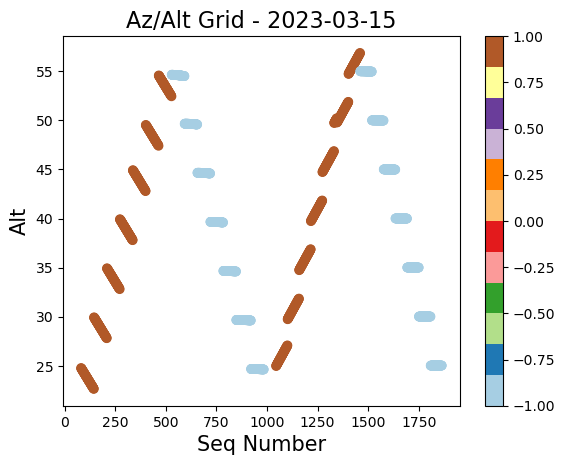

In [459]:
# plt.scatter(seq_num, alt*path, label='Forward')
# plt.scatter(seq_num, alt*(1-path), label='Backward')
plt.scatter(seq_num, alt, c=path, cmap='Paired')

# plt.ylim(20,)
plt.xlabel('Seq Number',fontsize=15)
plt.ylabel('Alt',fontsize=15)
# plt.legend()
plt.colorbar()
plt.title('Az/Alt Grid - %s'%today,fontsize=16)

Text(0.5, 1.0, 'Az/Alt Grid - 2023-03-15')

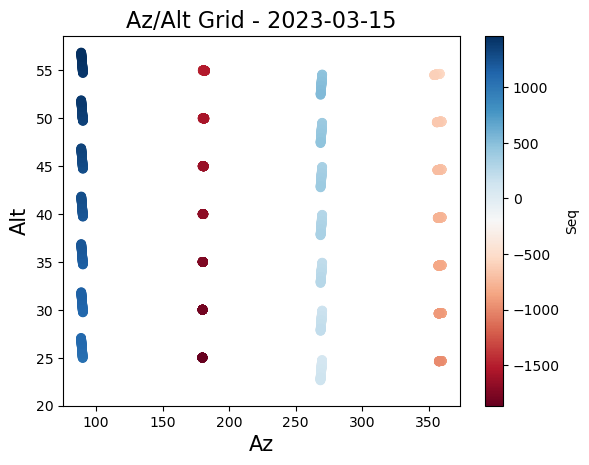

In [460]:
# plt.scatter(az, alt, c=seq_num, cmap='tab20c')
plt.scatter(az, alt, c=path*seq_num, cmap='RdBu')
plt.ylim(20,)
plt.xlabel('Az',fontsize=15)
plt.ylabel('Alt',fontsize=15)
plt.colorbar(label='Seq')
plt.title('Az/Alt Grid - 2023-03-15',fontsize=16)

The commanded coordinates:
```
az=270, el=25,30,35,40,45.
```

It's clear that the telescope moved from the inital commandaded poistion. The angle of this rotation should correlation with the sky movement. 



Text(0.5, 0, 'Alt deg')

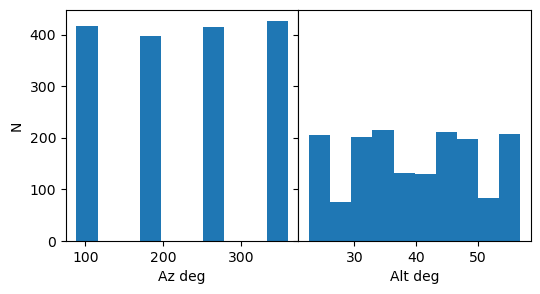

In [461]:
fig, (ax1, ax2) = plt.subplots(1,2 , figsize=(6,3), sharey='all')
fig.subplots_adjust(wspace=0.)
ax1.hist(az)
ax2.hist(alt)
ax1.set_ylabel('N')
ax1.set_xlabel('Az deg')
ax2.set_xlabel('Alt deg')

The grid is not perfect. In Az the number of exposures is about the same. Howeveer in Alt there are some scatter.

## Tracking the Sky

Here I stop at Az=240 to model the offsets of the actual targeted position.

```
01:47	81-400	
restarting grid. az=270, el=25,30,35,40,45.  faulted on slew to 50.

"tracking command not accepted by axis.  slewing command detected during slewing move."
```


The movement is constant in RA/DEC. The telescope is tracking the sky. Any variation observed in the residual of the sky should be due to the TMA mount.

In [497]:
sequences = [[81,380],[401,528]]
indices = np.empty((0,), dtype=int)
for i0, ie in sequences:
    _indices = np.arange(np.where(df['seq_num']==i0)[0][0], np.where(df['seq_num']==ie)[0][0], 1)
    indices = np.append(indices, _indices)

In [498]:
# the data for az=240 and el=25, 30, 35, 40, 45
d1 = df.iloc[indices].copy()

In [499]:
from scipy.cluster.vq import whiten, kmeans, vq, kmeans2

data = np.vstack([d1['Alt'].to_numpy(),d1['Az'].to_numpy()]).T

# code book generation
centroids, mean_value = kmeans(data, 7)
 
ix = np.argsort(np.hypot(centroids[:,0],centroids[:,1]))

# mapping the centroids
clusters, distances = vq(data, centroids[ix,:])
 
print("Cluster index :", clusters, "\n")

Cluster index : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6] 



In [500]:
d1['path'] = 1
d1['slews'] = clusters

In [501]:
from bokeh.palettes import Magma, Inferno, Plasma, Viridis, Cividis, RdBu
from matplotlib import colors
nslews = np.max(clusters)+2
mycolor = np.flip(RdBu[nslews],0)
mycolor2 = RdBu[nslews]
cmap = colors.ListedColormap(mycolor)

Text(0.5, 0.98, 'Forward Sequence - 0')

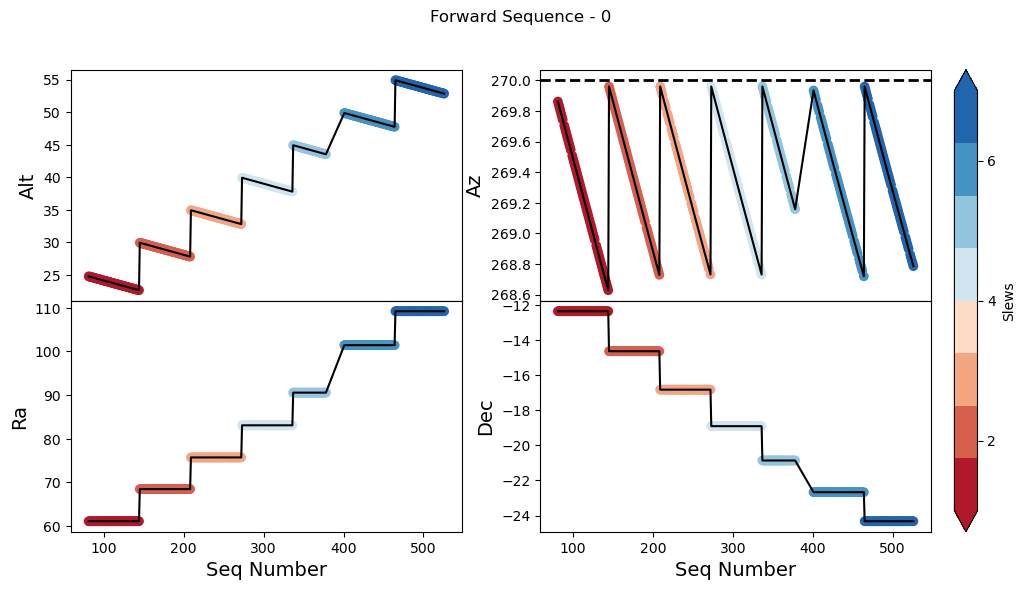

In [502]:
fig, (ax1, ax2) = plt.subplots(2,2, figsize=(12,6), sharex='all')
fig.subplots_adjust(wspace=0.2, hspace=0.)

d1['Alt'].plot(color='k', ax=ax1[0])
im = ax1[0].scatter(d1.index, d1['Alt'], c=d1['slews']+1., cmap=cmap)
# for el in [25,30,35,40,45]:
#     ax1[0].axhline(el, ls='--', color='gray', lw=2)

ax1[0].set_ylabel('Alt',fontsize=14)
d1['Az'].plot(color='k', ax=ax1[1])
ax1[1].axhline(270, ls='--', color='k', lw=2)
im = ax1[1].scatter(d1.index, d1['Az'], c=d1['slews']+1., cmap=cmap)

ax1[0].set_ylabel('Alt',fontsize=14)
ax1[1].set_ylabel('Az',fontsize=14)
ax1[1].set_xlabel('Seq Number',fontsize=14)
ax1[0].set_xlabel('Seq Number',fontsize=14)

d1['Ra'].plot(color='k', ax=ax2[0])
im = ax2[0].scatter(d1.index, d1['Ra'], c=d1['slews']+1., cmap=cmap)
d1['Dec'].plot(color='k', ax=ax2[1])
im = ax2[1].scatter(d1.index, d1['Dec'], c=d1['slews']+1., cmap=cmap)

ax2[0].set_ylabel('Ra',fontsize=14)
ax2[1].set_ylabel('Dec',fontsize=14)
ax2[0].set_xlabel('Seq Number',fontsize=14)
ax2[1].set_xlabel('Seq Number',fontsize=14)

cb = fig.colorbar(im, label='Slews', ax=[ax1[0],ax1[1],ax2[0],ax2[1]], location='right', fraction=0.05, pad=0.025, extend='both')
cb.ax.locator_params(nbins=5)

fig.suptitle('Forward Sequence - 0')
# fig.savefig('forward_sequence_0_ra.png', dpi=75)


The clustering algorithm works

### Residual

$$
\delta Ra = Ra-Ra_0
$$

The $Ra_0$ is the baseline sky position.

In [504]:
slews_ids = np.unique(d1['slews'])

keys = [np.where(d1['slews']==sid)[0] for sid in slews_ids] 

In [505]:
def get_residual(ycol, keys, df=d1):
    yvec = df[ycol].to_numpy()
    res = np.zeros_like(yvec)
    for ix in keys:
        res[ix] = (yvec[ix]-yvec[ix][0])*3600
    return res

def get_baseline(ycol, keys, df=d1):
    yvec = df[ycol].to_numpy()
    base = np.zeros_like(yvec)
    for ix in keys:
        base[ix] = yvec[ix][0]
    return base

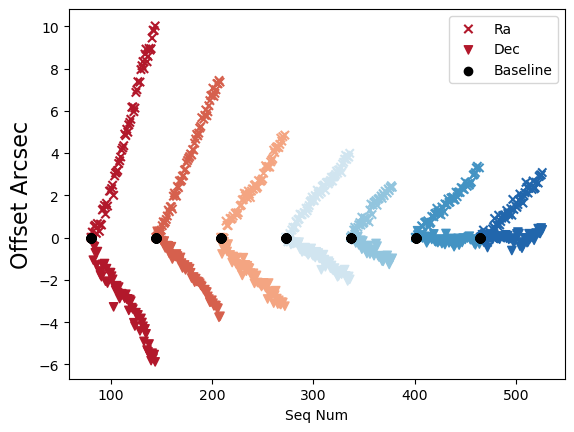

In [506]:
deltaRa = get_residual('Calculated Ra wide', keys)
deltaDec = get_residual('Calculated Dec wide', keys)

baseAz = get_baseline('Calculated Az wide', keys)
baseAlt = get_baseline('Calculated Alt wide', keys)
baseSeq = get_baseline('seq_num', keys)

plt.scatter(d1.seq_num, deltaRa, marker='x', c=d1.slews+1, cmap=cmap, label='Ra')
plt.scatter(d1.seq_num, deltaDec, marker='v', c=d1.slews+1, cmap=cmap, label='Dec')
plt.scatter(baseSeq, np.zeros_like(baseSeq), label='Baseline', color='k')

plt.ylabel('Offset Arcsec', fontsize=16)
plt.xlabel('Seq Num')
plt.legend()
plt.savefig('offset_seqNum.png', dpi=75)

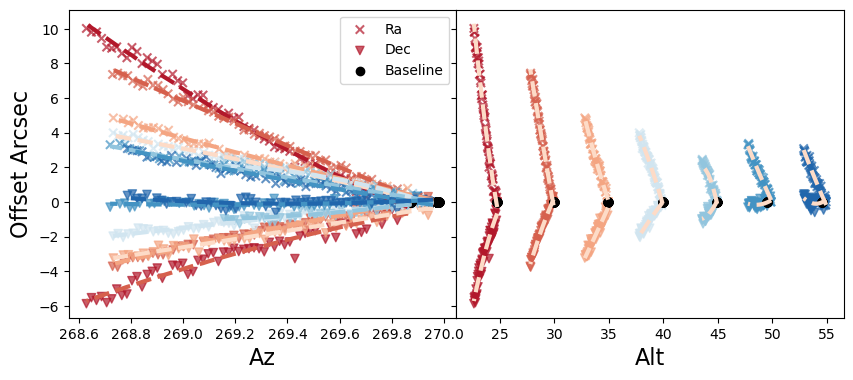

In [507]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharey='all')
fig.subplots_adjust(wspace=0.)

ax1.scatter(d1.Az, deltaRa, marker='x', c=d1.slews+1, cmap=cmap, label='Ra', alpha=0.7)
ax1.scatter(d1.Az, deltaDec, marker='v', c=d1.slews+1, cmap=cmap, label='Dec', alpha=0.7)
ax1.scatter(baseAz, np.zeros_like(baseAz), color='k', label='Baseline')

ax1.set_xlabel('Az', fontsize=16)
ax1.set_ylabel('Offset Arcsec', fontsize=16)
ax1.legend()

ax2.scatter(d1.Alt, deltaRa, marker='x', c=d1.slews+1, cmap=cmap, label='Ra', alpha=0.7)
ax2.scatter(d1.Alt, deltaDec, marker='v', c=d1.slews+1, cmap=cmap, label='Dec', alpha=0.7)
ax2.scatter(baseAlt, np.zeros_like(baseAz), label='Baseline', color='k')

for i in range(7):
    x = np.vstack([d1.Az.iloc[keys[i]]-270, d1.Alt.iloc[keys[i]]-els[i]])
    dra = function(x, *pars1[i])
    ddec = function(x, *pars2[i])
    ax1.plot( d1.Az.iloc[keys[i]], dra, color=mycolor[i], lw=3, ls='--')
    ax2.plot( d1.Alt.iloc[keys[i]], dra, color=mycolor2[4], lw=3, ls='--')    
    ax1.plot( d1.Az.iloc[keys[i]], ddec, color=mycolor[i+1], lw=3, ls='--')
    ax2.plot( d1.Alt.iloc[keys[i]], ddec, color=mycolor2[4], lw=3, ls='--')

ax2.set_xlabel('Alt', fontsize=16)
plt.savefig('offset_AzAlt.png', dpi=75)

In [508]:
def plot_azAlt_fit(x, y, pars):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharey='all')
    fig.subplots_adjust(wspace=0.)
    
    xline = np.linspace(np.min(x[0]),np.max(x[0]),100)
    ypred = function(x,*pars)
    
    ax1.scatter(x[0], ypred-y)
    ax2.scatter(x[1], ypred-y)
    #ax1.scatter(x[0], y)

[ 290.44251698 -172.66066586   -1.85328019]

[ 33.89211782 -23.23255309  -0.54044932]

[ 42.15676039 -26.46249566  -0.12418972]

[-41.10952497  21.75969341  -0.15248923]

[-3.71638835e+01  1.96339636e+01 -1.80654989e-02]

[ 8.16357682 -6.11542958 -0.08557303]

[ 9.8183872  -7.11842729 -0.31439019]

[-1.64452578e+02  9.73220347e+01  1.01221889e-01]

[-60.82903022  36.83939977   0.39167353]

[ 5.12751414 -1.58390128 -0.24283563]

[-10.96588591   7.19957807   0.06101776]

[ 3.82175402e+01 -2.12007860e+01 -1.08377810e-02]

[ 23.94705633 -13.55245852   0.06723248]

[ 40.81471387 -23.23163798   0.04954691]



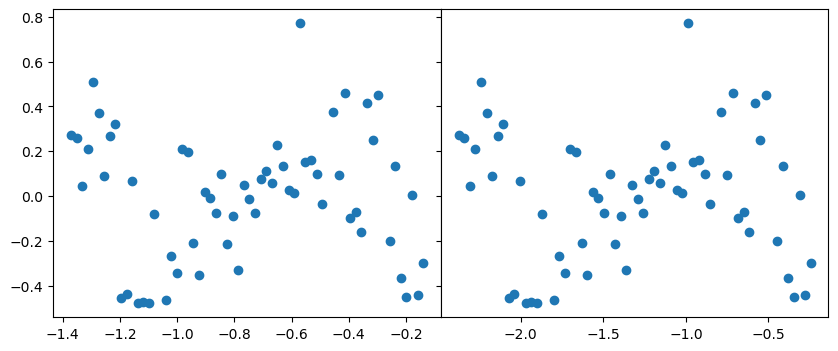

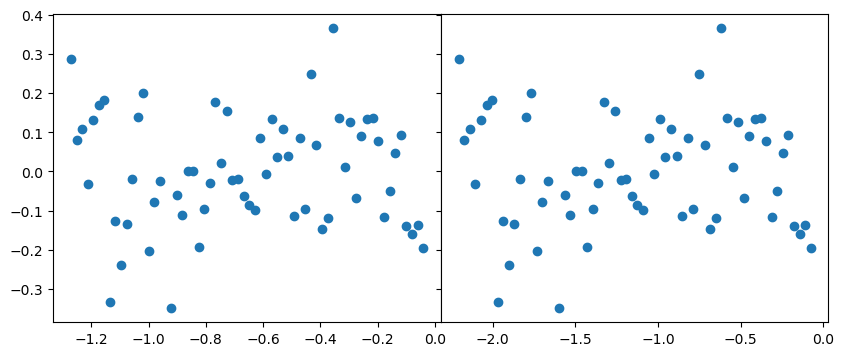

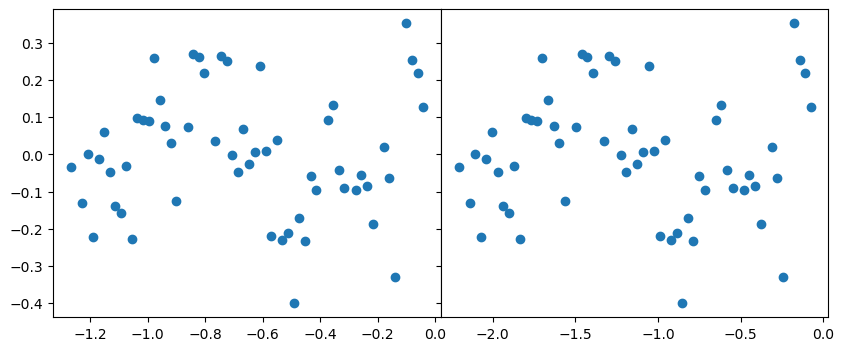

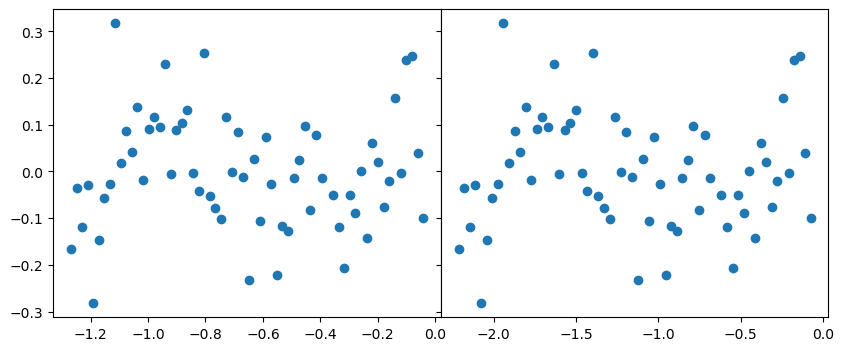

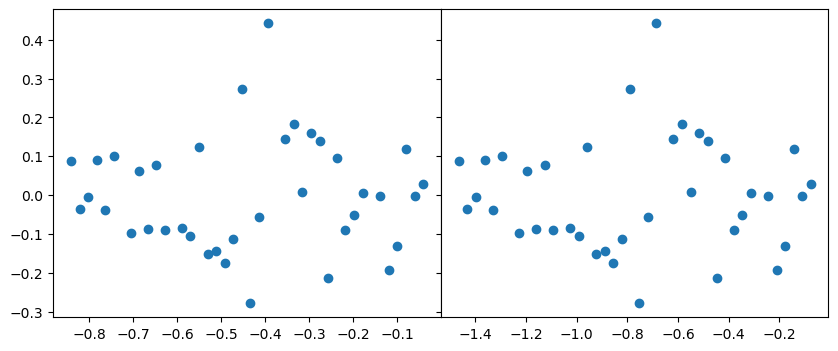

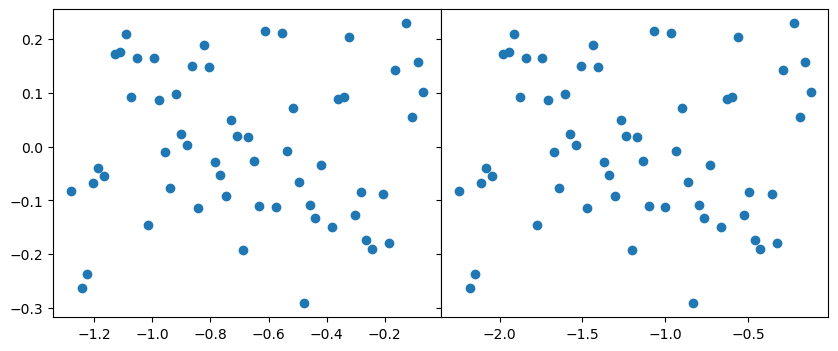

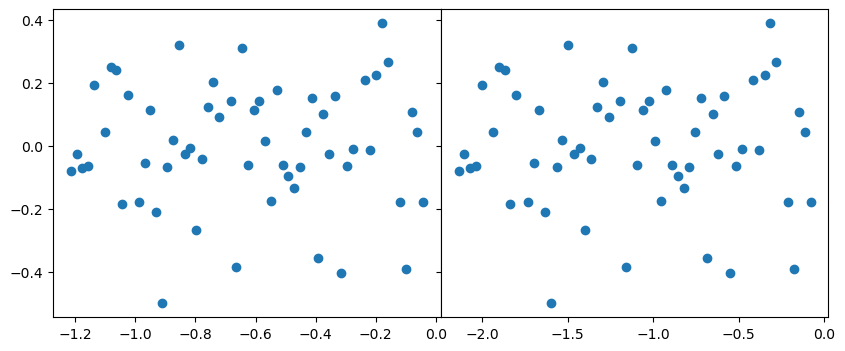

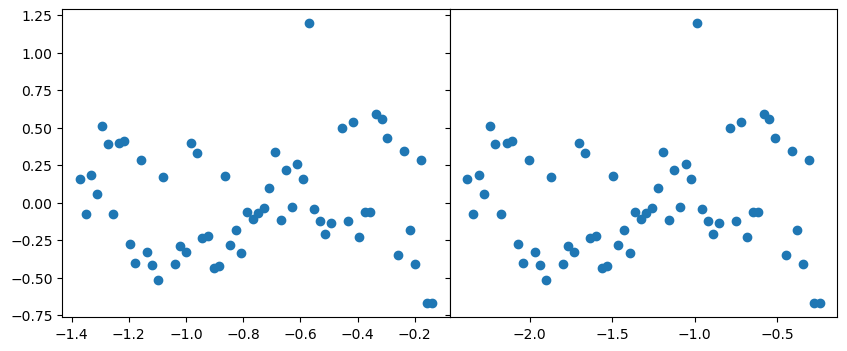

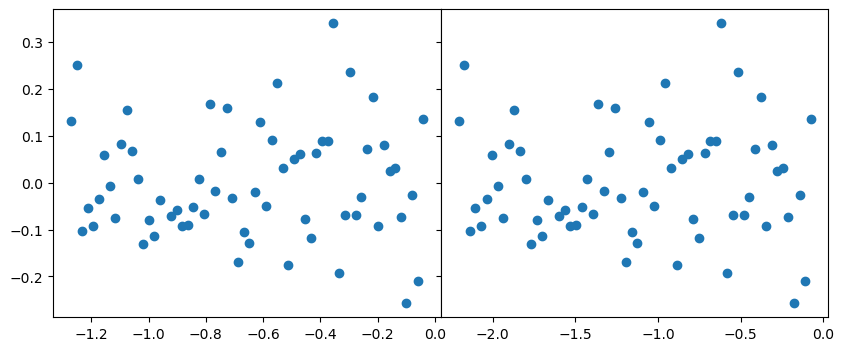

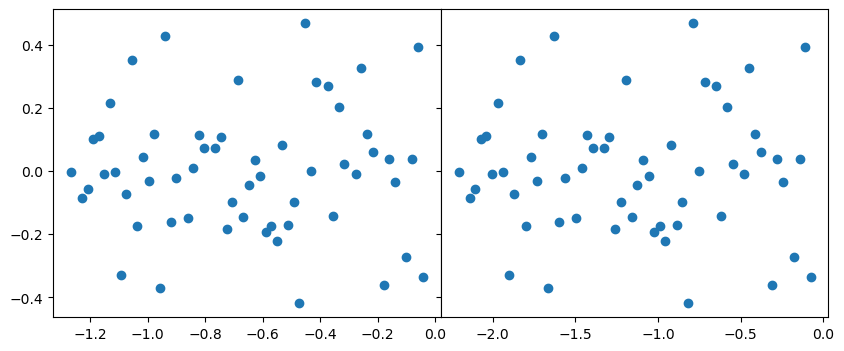

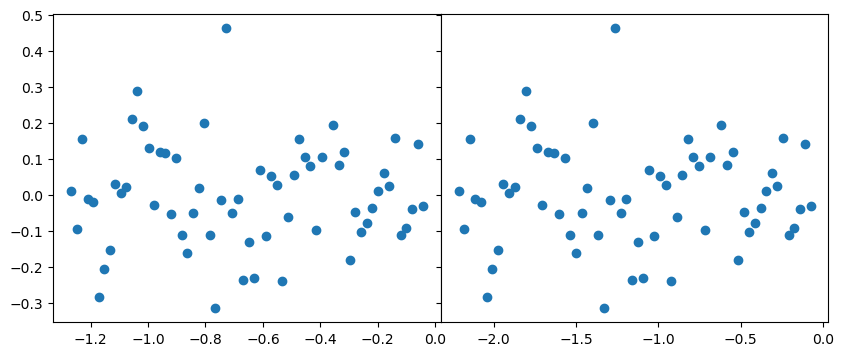

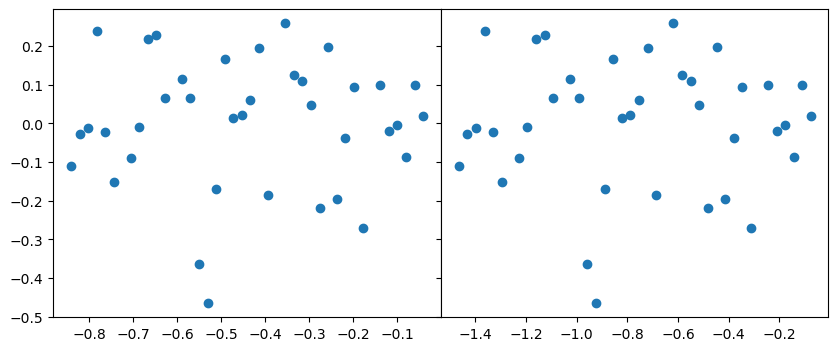

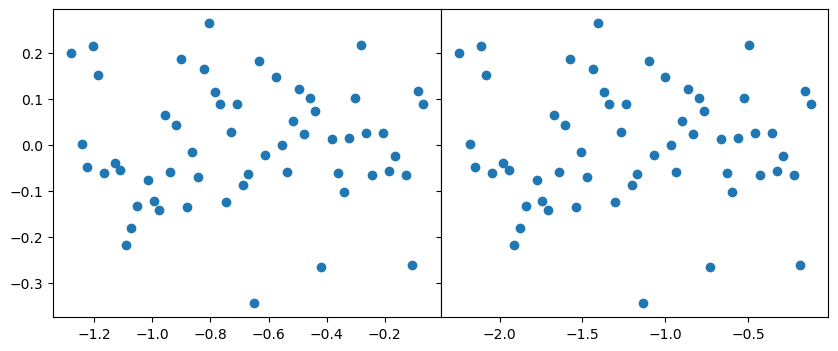

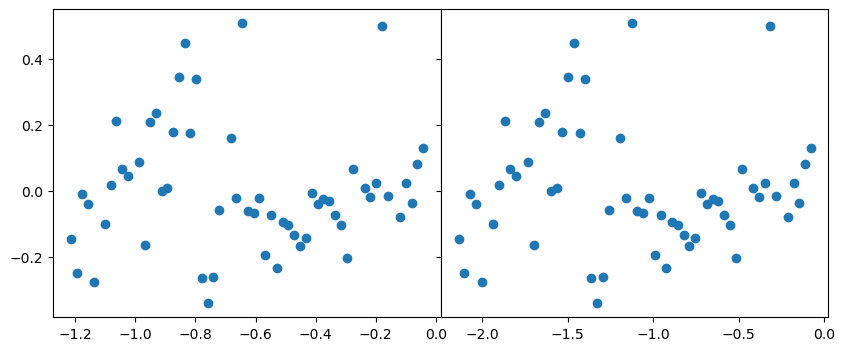

In [509]:
from scipy.optimize import curve_fit
def function(data, a, b, c ):
    x = data[0]
    y = data[1]
    return a * x + b * y + c

pars1 = []
els = [25,30,35,40,45,50, 55]

for i,ix in enumerate(keys):
    x0, x1 = d1.Az.iloc[ix]-270. , d1.Alt.iloc[ix]-els[i]
    xn = np.vstack([x0,x1])
    parameters, covariance = curve_fit(function, xn, deltaRa[ix])
    plot_azAlt_fit(xn, deltaRa[ix], parameters)
    print(parameters)
    print()
    pars1.append(parameters)
    
pars2 = []
for i,ix in enumerate(keys):
    x0, x1 = d1.Az.iloc[ix]-270. , d1.Alt.iloc[ix]-els[i]
    xn = np.vstack([x0,x1])
    parameters, covariance = curve_fit(function, xn, deltaDec[ix])
    plot_azAlt_fit(xn, deltaDec[ix], parameters)
    print(parameters)
    print()
    pars2.append(parameters)

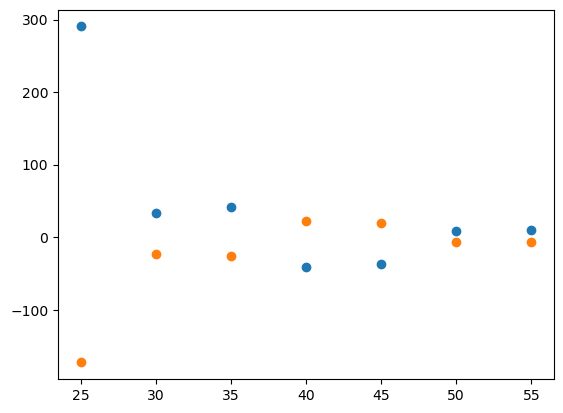

In [510]:
plt.scatter(els, np.array(pars1)[:,0])
plt.scatter(els, np.array(pars1)[:,1])

## Tracking the Sky

Here I stop at Az=240 to model the offsets of the actual targeted position.

```
01:47	81-400	
restarting grid. az=270, el=25,30,35,40,45.  faulted on slew to 50.

"tracking command not accepted by axis.  slewing command detected during slewing move."
```


The movement is constant in RA/DEC. The telescope is tracking the sky. Any variation observed in the residual of the sky should be due to the TMA mount.

In [628]:
# sequences = [[1463,df['seq_num'].max()]]
sequences = [[1045, 1462]]
indices = np.empty((0,), dtype=int)
for i0, ie in sequences:
    _indices = np.arange(np.where(df['seq_num']==i0)[0][0], np.where(df['seq_num']==ie)[0][0], 1)
    indices = np.append(indices, _indices)

In [629]:
# the data for az=240 and el=25, 30, 35, 40, 45
d1 = df.iloc[indices].copy()

In [630]:
from scipy.cluster.vq import whiten, kmeans, vq, kmeans2

data = np.vstack([d1['Alt'].to_numpy(),d1['Az'].to_numpy()]).T

# code book generation
centroids, mean_value = kmeans(data, 7)
 
ix = np.argsort(np.hypot(centroids[:,0],centroids[:,1]))

# mapping the centroids
clusters, distances = vq(data, centroids[ix,:])
 
print("Cluster index :", clusters, "\n")

Cluster index : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6] 



In [631]:
d1['path'] = 1
d1['slews'] = clusters

In [632]:
from bokeh.palettes import Magma, Inferno, Plasma, Viridis, Cividis, RdBu
from matplotlib import colors
nslews = np.max(clusters)+2
mycolor = np.flip(RdBu[nslews],0)
mycolor2 = RdBu[nslews]
cmap = colors.ListedColormap(mycolor)

Text(0.5, 0.98, 'Forward Sequence - 0')

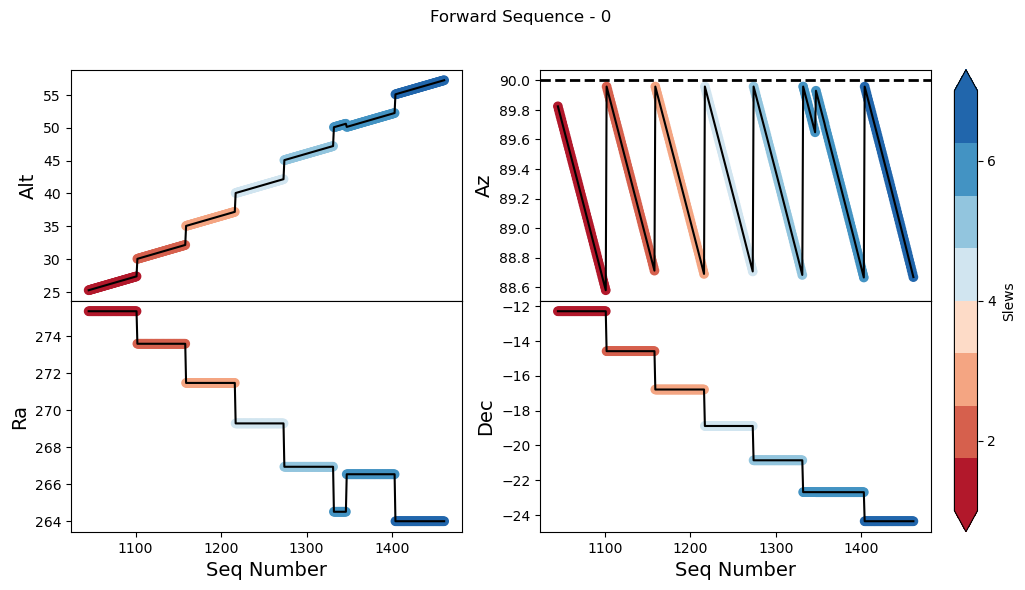

In [635]:
fig, (ax1, ax2) = plt.subplots(2,2, figsize=(12,6), sharex='all')
fig.subplots_adjust(wspace=0.2, hspace=0.)

d1['Alt'].plot(color='k', ax=ax1[0])
im = ax1[0].scatter(d1.index, d1['Alt'], c=d1['slews']+1., cmap=cmap)
# for el in [25,30,35,40,45]:
#     ax1[0].axhline(el, ls='--', color='gray', lw=2)

ax1[0].set_ylabel('Alt',fontsize=14)
d1['Az'].plot(color='k', ax=ax1[1])
ax1[1].axhline(90, ls='--', color='k', lw=2)
im = ax1[1].scatter(d1.index, d1['Az'], c=d1['slews']+1., cmap=cmap)

ax1[0].set_ylabel('Alt',fontsize=14)
ax1[1].set_ylabel('Az',fontsize=14)
ax1[1].set_xlabel('Seq Number',fontsize=14)
ax1[0].set_xlabel('Seq Number',fontsize=14)

d1['Ra'].plot(color='k', ax=ax2[0])
im = ax2[0].scatter(d1.index, d1['Ra'], c=d1['slews']+1., cmap=cmap)
d1['Dec'].plot(color='k', ax=ax2[1])
im = ax2[1].scatter(d1.index, d1['Dec'], c=d1['slews']+1., cmap=cmap)

ax2[0].set_ylabel('Ra',fontsize=14)
ax2[1].set_ylabel('Dec',fontsize=14)
ax2[0].set_xlabel('Seq Number',fontsize=14)
ax2[1].set_xlabel('Seq Number',fontsize=14)

cb = fig.colorbar(im, label='Slews', ax=[ax1[0],ax1[1],ax2[0],ax2[1]], location='right', fraction=0.05, pad=0.025, extend='both')
cb.ax.locator_params(nbins=5)

fig.suptitle('Forward Sequence - 0')
# fig.savefig('forward_sequence_0_ra.png', dpi=75)


The clustering algorithm works

### Residual

$$
\delta Ra = Ra-Ra_0
$$

The $Ra_0$ is the baseline sky position.

In [636]:
slews_ids = np.unique(d1['slews'])

keys = [np.where(d1['slews']==sid)[0] for sid in slews_ids] 

In [637]:
def get_residual(ycol, keys, df=d1):
    yvec = df[ycol].to_numpy()
    res = np.zeros_like(yvec)
    for ix in keys:
        res[ix] = (yvec[ix]-yvec[ix][0])*3600
    return res

def get_baseline(ycol, keys, df=d1):
    yvec = df[ycol].to_numpy()
    base = np.zeros_like(yvec)
    for ix in keys:
        base[ix] = yvec[ix][0]
    return base

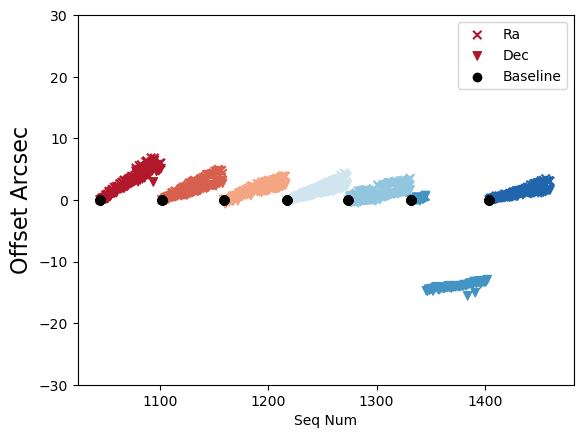

In [642]:
deltaRa = get_residual('Calculated Ra wide', keys)
deltaDec = get_residual('Calculated Dec wide', keys)

baseAz = get_baseline('Calculated Az wide', keys)
baseAlt = get_baseline('Calculated Alt wide', keys)
baseSeq = get_baseline('seq_num', keys)

plt.scatter(d1.seq_num, deltaRa, marker='x', c=d1.slews+1, cmap=cmap, label='Ra')
plt.scatter(d1.seq_num, deltaDec, marker='v', c=d1.slews+1, cmap=cmap, label='Dec')
plt.scatter(baseSeq, np.zeros_like(baseSeq), label='Baseline', color='k')
plt.ylim(-30,30)
plt.ylabel('Offset Arcsec', fontsize=16)
plt.xlabel('Seq Num')
plt.legend()
plt.savefig('offset_seqNum.png', dpi=75)

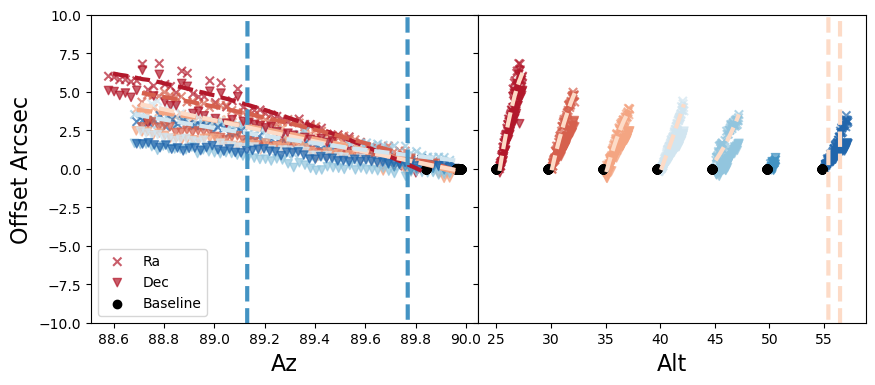

In [649]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharey='all')
fig.subplots_adjust(wspace=0.)

ax1.scatter(d1.Az, deltaRa, marker='x', c=d1.slews+1, cmap=cmap, label='Ra', alpha=0.7)
ax1.scatter(d1.Az, deltaDec, marker='v', c=d1.slews+1, cmap=cmap, label='Dec', alpha=0.7)
ax1.scatter(baseAz, np.zeros_like(baseAz), color='k', label='Baseline')

ax1.set_xlabel('Az', fontsize=16)
ax1.set_ylabel('Offset Arcsec', fontsize=16)
ax1.legend()

ax2.scatter(d1.Alt, deltaRa, marker='x', c=d1.slews+1, cmap=cmap, label='Ra', alpha=0.7)
ax2.scatter(d1.Alt, deltaDec, marker='v', c=d1.slews+1, cmap=cmap, label='Dec', alpha=0.7)
ax2.scatter(baseAlt, np.zeros_like(baseAz), label='Baseline', color='k')

for i in range(7):
    x = np.vstack([d1.Az.iloc[keys[i]]-270, d1.Alt.iloc[keys[i]]-els[i]])
    dra = function(x, *pars1[i])
    ddec = function(x, *pars2[i])
    ax1.plot( d1.Az.iloc[keys[i]], dra, color=mycolor[i], lw=3, ls='--')
    ax2.plot( d1.Alt.iloc[keys[i]], dra, color=mycolor2[4], lw=3, ls='--')    
    ax1.plot( d1.Az.iloc[keys[i]], ddec, color=mycolor[i+1], lw=3, ls='--')
    ax2.plot( d1.Alt.iloc[keys[i]], ddec, color=mycolor2[4], lw=3, ls='--')

ax1.set_ylim(-10,10)

ax2.set_xlabel('Alt', fontsize=16)
plt.savefig('offset_AzAlt.png', dpi=75)

In [644]:
def plot_azAlt_fit(x, y, pars):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharey='all')
    fig.subplots_adjust(wspace=0.)
    
    xline = np.linspace(np.min(x[0]),np.max(x[0]),100)
    ypred = function(x,*pars)
    
    ax1.scatter(x[0], ypred-y)
    ax2.scatter(x[1], ypred-y)
    #ax1.scatter(x[0], y)

[  244.36016501   147.20819911 48400.60386871]

[  104.97314709    64.32695    20181.80971312]

[   82.9190611     50.96595602 15435.00432599]

[  -13.80566434    -6.16732118 -2485.27286369]

[  -32.57750352   -18.00345015 -5683.55422875]

[  483502.60116034   290776.28028953 81217953.12594533]

[1.34508747e+06 8.03433019e+05 2.18011463e+08]

[  119.59369861    73.27597434 34487.6972489 ]

[   -73.59741267    -42.05848078 -20712.71310447]

[   69.75313287    42.54046494 19258.46439076]

[   -8.63834685    -3.99159952 -2332.60234   ]

[   -55.61889212    -32.16331209 -14696.00544311]

[   85537.31675974    50857.30954872 22077934.19963524]

[1.88983003e+06 1.12881118e+06 4.76387958e+08]



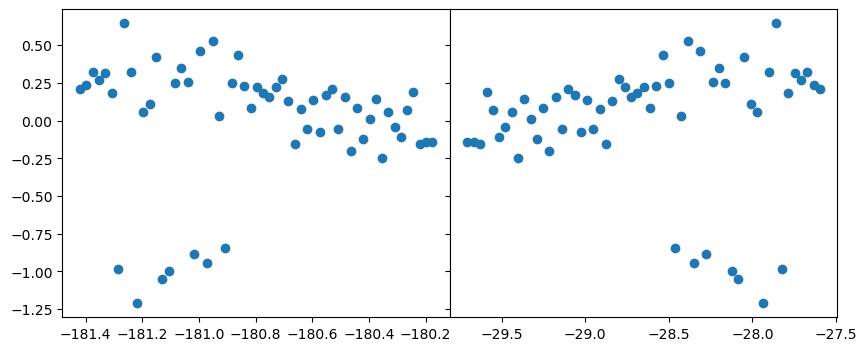

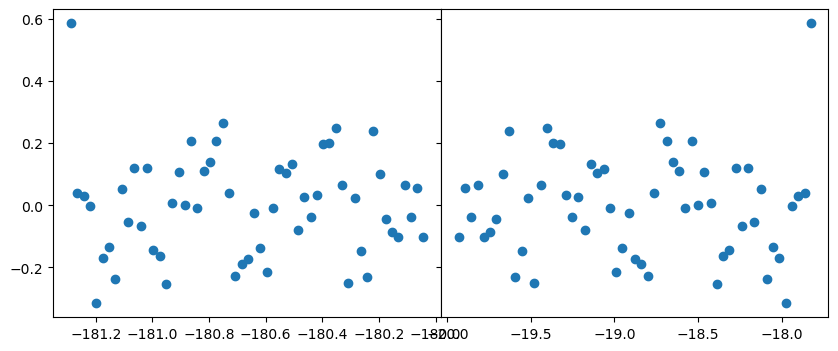

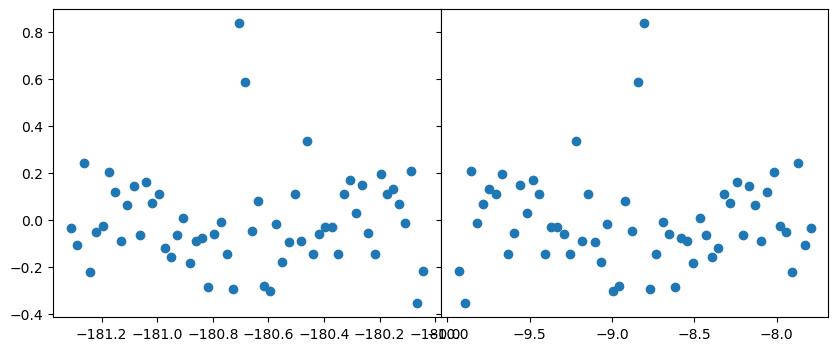

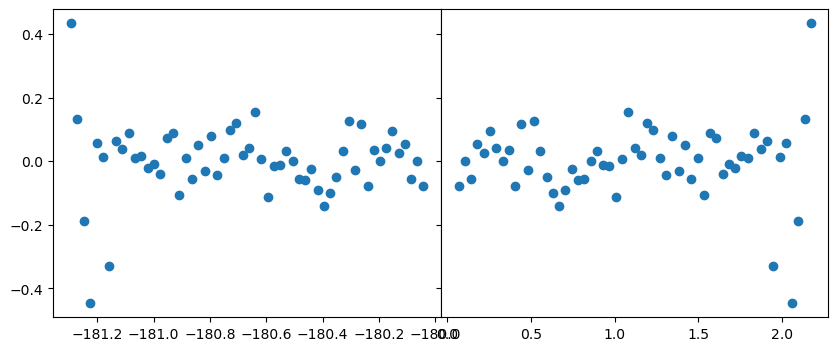

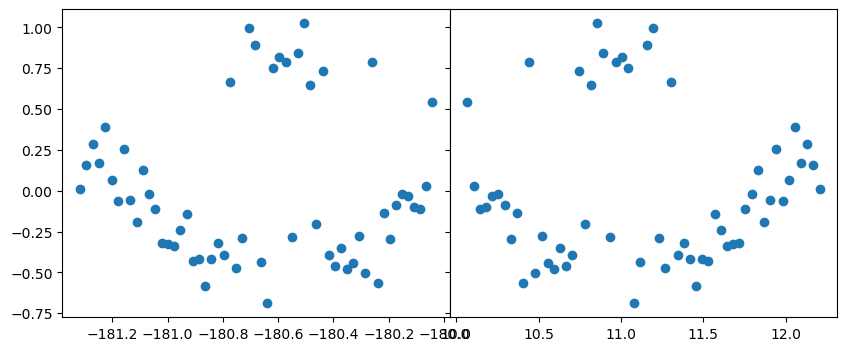

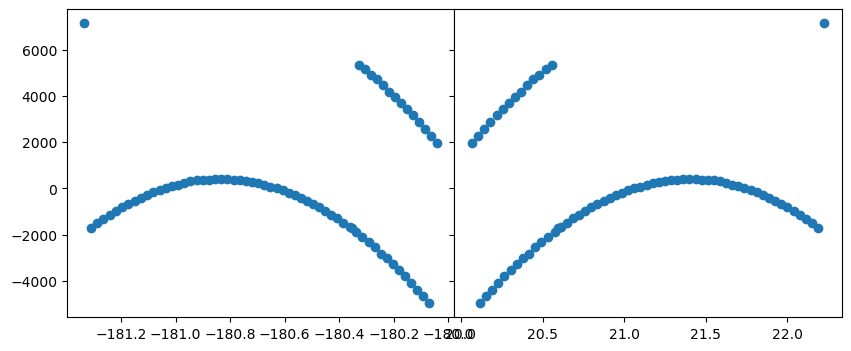

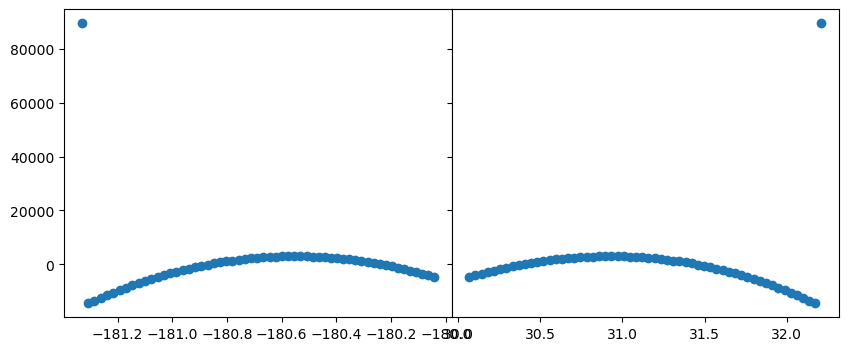

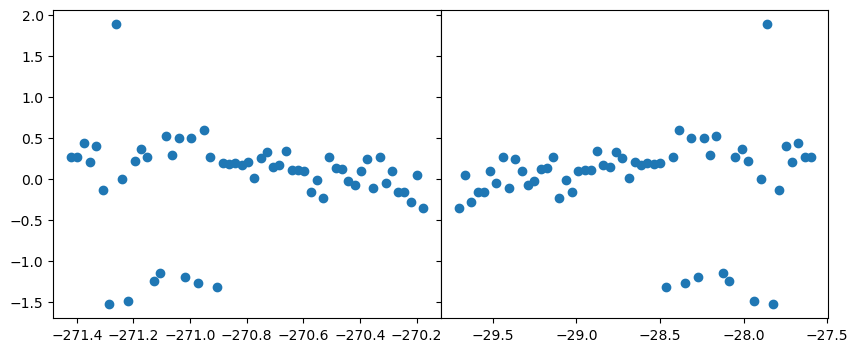

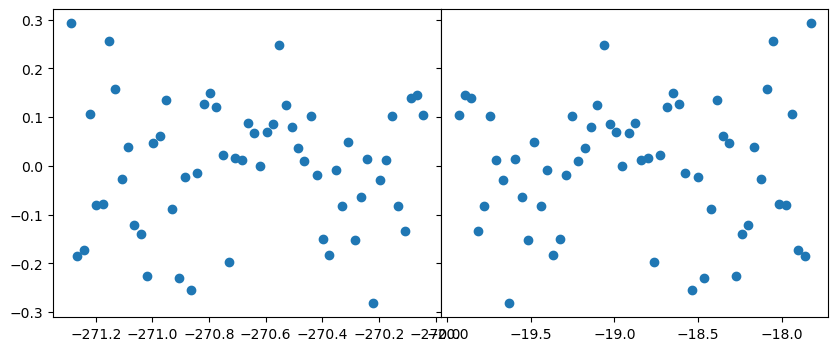

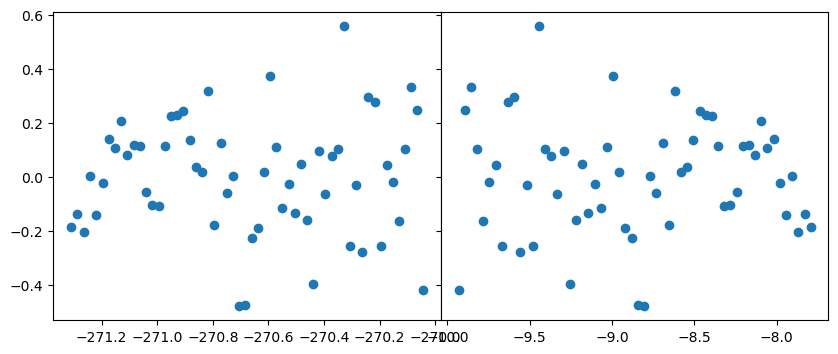

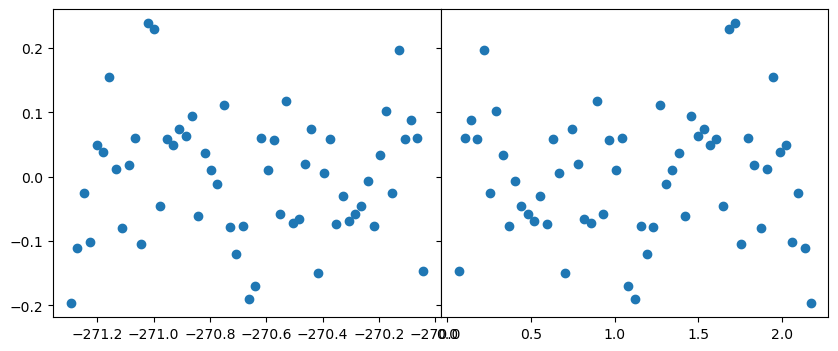

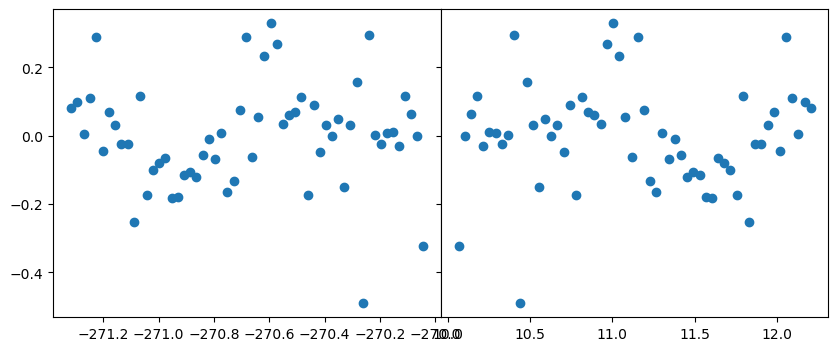

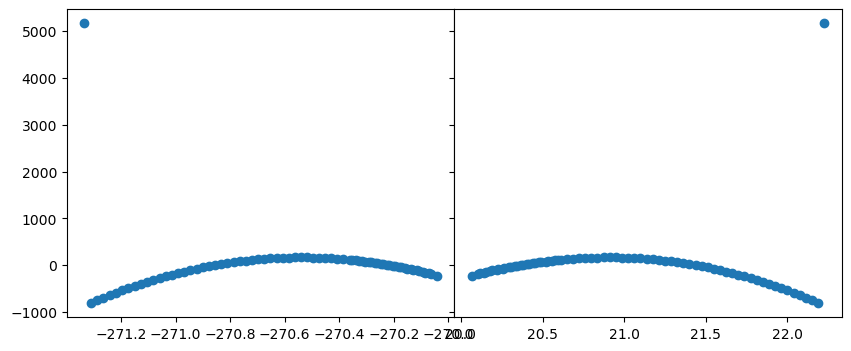

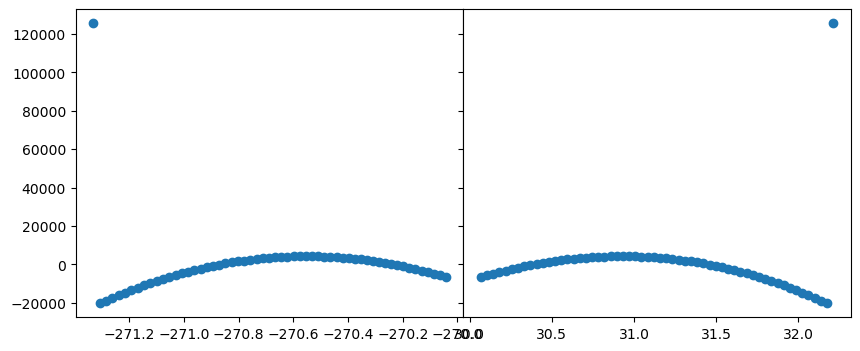

In [645]:
from scipy.optimize import curve_fit
def function(data, a, b, c ):
    x = data[0]
    y = data[1]
    return a * x + b * y + c

pars1 = []
els = np.arange(55,20,-5)

for i,ix in enumerate(keys):
    x0, x1 = d1.Az.iloc[ix]-270. , d1.Alt.iloc[ix]-els[i]
    xn = np.vstack([x0,x1])
    parameters, covariance = curve_fit(function, xn, deltaRa[ix])
    plot_azAlt_fit(xn, deltaRa[ix], parameters)
    print(parameters)
    print()
    pars1.append(parameters)
    
pars2 = []
for i,ix in enumerate(keys):
    x0, x1 = d1.Az.iloc[ix]-360. , d1.Alt.iloc[ix]-els[i]
    xn = np.vstack([x0,x1])
    parameters, covariance = curve_fit(function, xn, deltaDec[ix])
    plot_azAlt_fit(xn, deltaDec[ix], parameters)
    print(parameters)
    print()
    pars2.append(parameters)

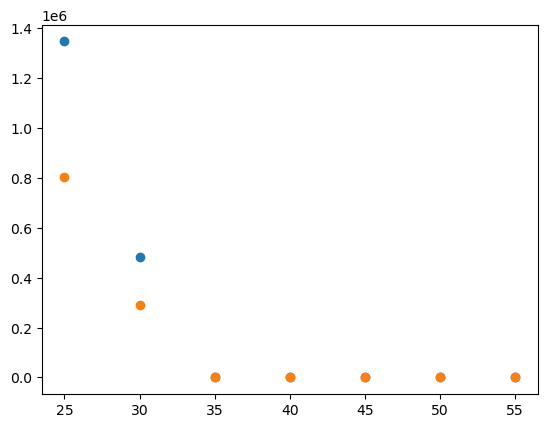

In [646]:
plt.scatter(els, np.array(pars1)[:,0])
plt.scatter(els, np.array(pars1)[:,1])